In [1]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer
from tensorflow.nn import local_response_normalization  # lrn

In [2]:
# modeling(functional API)
input_shape = (224, 224, 3)  # 논문에서 제시된 shape
x = Input(shape = input_shape, name='INPUT')

# CONV (Convolutional Layer)
conv1 = Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, name='CONV_1')(x)
pool1 = MaxPooling2D((3,3), strides=2, name='POOL_1')(conv1)  # overlapped pooling
# lrn1 = local_response_normalization(conv1,depth_radius=5, bias=2, alpha=0.0001, beta=0.75) 
lrn1 = BatchNormalization(name='LRN_1')(pool1)

conv2 = Conv2D(filters=256, kernel_size=5, activation='relu', strides=1, padding='same', name='CONV_2')(lrn1)
pool2 = MaxPooling2D((3,3), strides=2, name='POOL_2')(conv2)
# lrn2 = local_response_normalization(conv2,depth_radius=5, bias=2,  alpha=0.0001, beta=0.75)
lrn2 = BatchNormalization(name='LRN_2')(pool2)

conv3 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_3')(lrn2)
conv4 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_4')(conv3)
conv5 = Conv2D(filters=256, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_5')(conv4)
pool3 = MaxPooling2D((3,3), strides=2, name='POOL_3')(conv5)

# FC (Fully Connected Layer)
f = Flatten()(pool3)
f = Dense(4096, activation='relu', name='FC_1')(f)
f = Dropout(0.5)(f)  # 논문 parameter 0.5 이용
f = Dense(4096, activation='relu', name='FC_2')(f)
f = Dropout(0.5)(f)
out = Dense(1000, activation='softmax', name='OUTPUT')(f)

model = Model(inputs=x, outputs=out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ INPUT (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_1 (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ POOL_1 (MaxPooling2D)           │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LRN_1 (BatchNormalization)      │ (None, 26, 26, 96)     │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_2 (Conv2D)                 │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ POOL_2 (MaxPooling2D)           │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LRN_2 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_3 (Conv2D)                 │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_4 (Conv2D)                 │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_5 (Conv2D)                 │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ POOL_3 (MaxPooling2D)           │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC_1 (Dense)                    │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC_2 (Dense)                    │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUTPUT (Dense)                  │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,845,416 (193.96 MB)

 Trainable params: 50,844,712 (193.96 MB)

 Non-trainable params: 704 (2.75 KB)

In [3]:
# cifar10 data load
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
print(img_height, img_width)

32 32


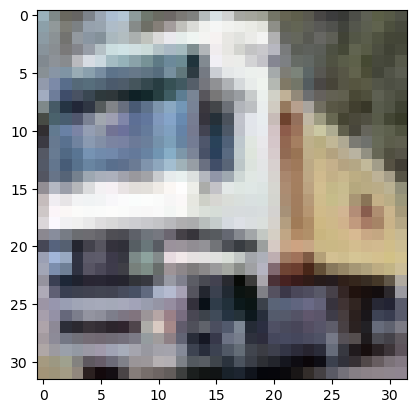

In [6]:
plt.imshow(x_train[1])

In [7]:
batch_size = 128
num_classes = 10
epochs = 10 #데이터 학습 횟수

y_train = to_categorical(y_train, num_classes)  # category화 
y_test = to_categorical(y_test, num_classes)

model = Sequential() #순차적 구조 모델 생성
# model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# for original Alexnet
model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
y_train.shape

(50000, 10)

In [9]:
#손실함수, 최적화 알고리즘, 평가지표 설정
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
#모델 학습
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10, 
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.3593 - loss: 1.8339 - val_accuracy: 0.5495 - val_loss: 1.2623
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.6011 - loss: 1.1414 - val_accuracy: 0.5928 - val_loss: 1.1724
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.6794 - loss: 0.9267 - val_accuracy: 0.6507 - val_loss: 1.0334
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7326 - loss: 0.7820 - val_accuracy: 0.6763 - val_loss: 0.9600
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.7725 - loss: 0.6792 - val_accuracy: 0.6423 - val_loss: 1.1042
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8035 - loss: 0.5815 - val_accuracy: 0.7108 - val_loss: 0.8855
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8344 - loss: 0.4902 - val_accuracy: 0.6837 - val_loss: 1.0357
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8584 - loss: 0.4283 - 

In [10]:
#모델 평가
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7315 - loss: 0.9862
Test loss: 0.9840242266654968
Test accuracy: 0.7318000197410583
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


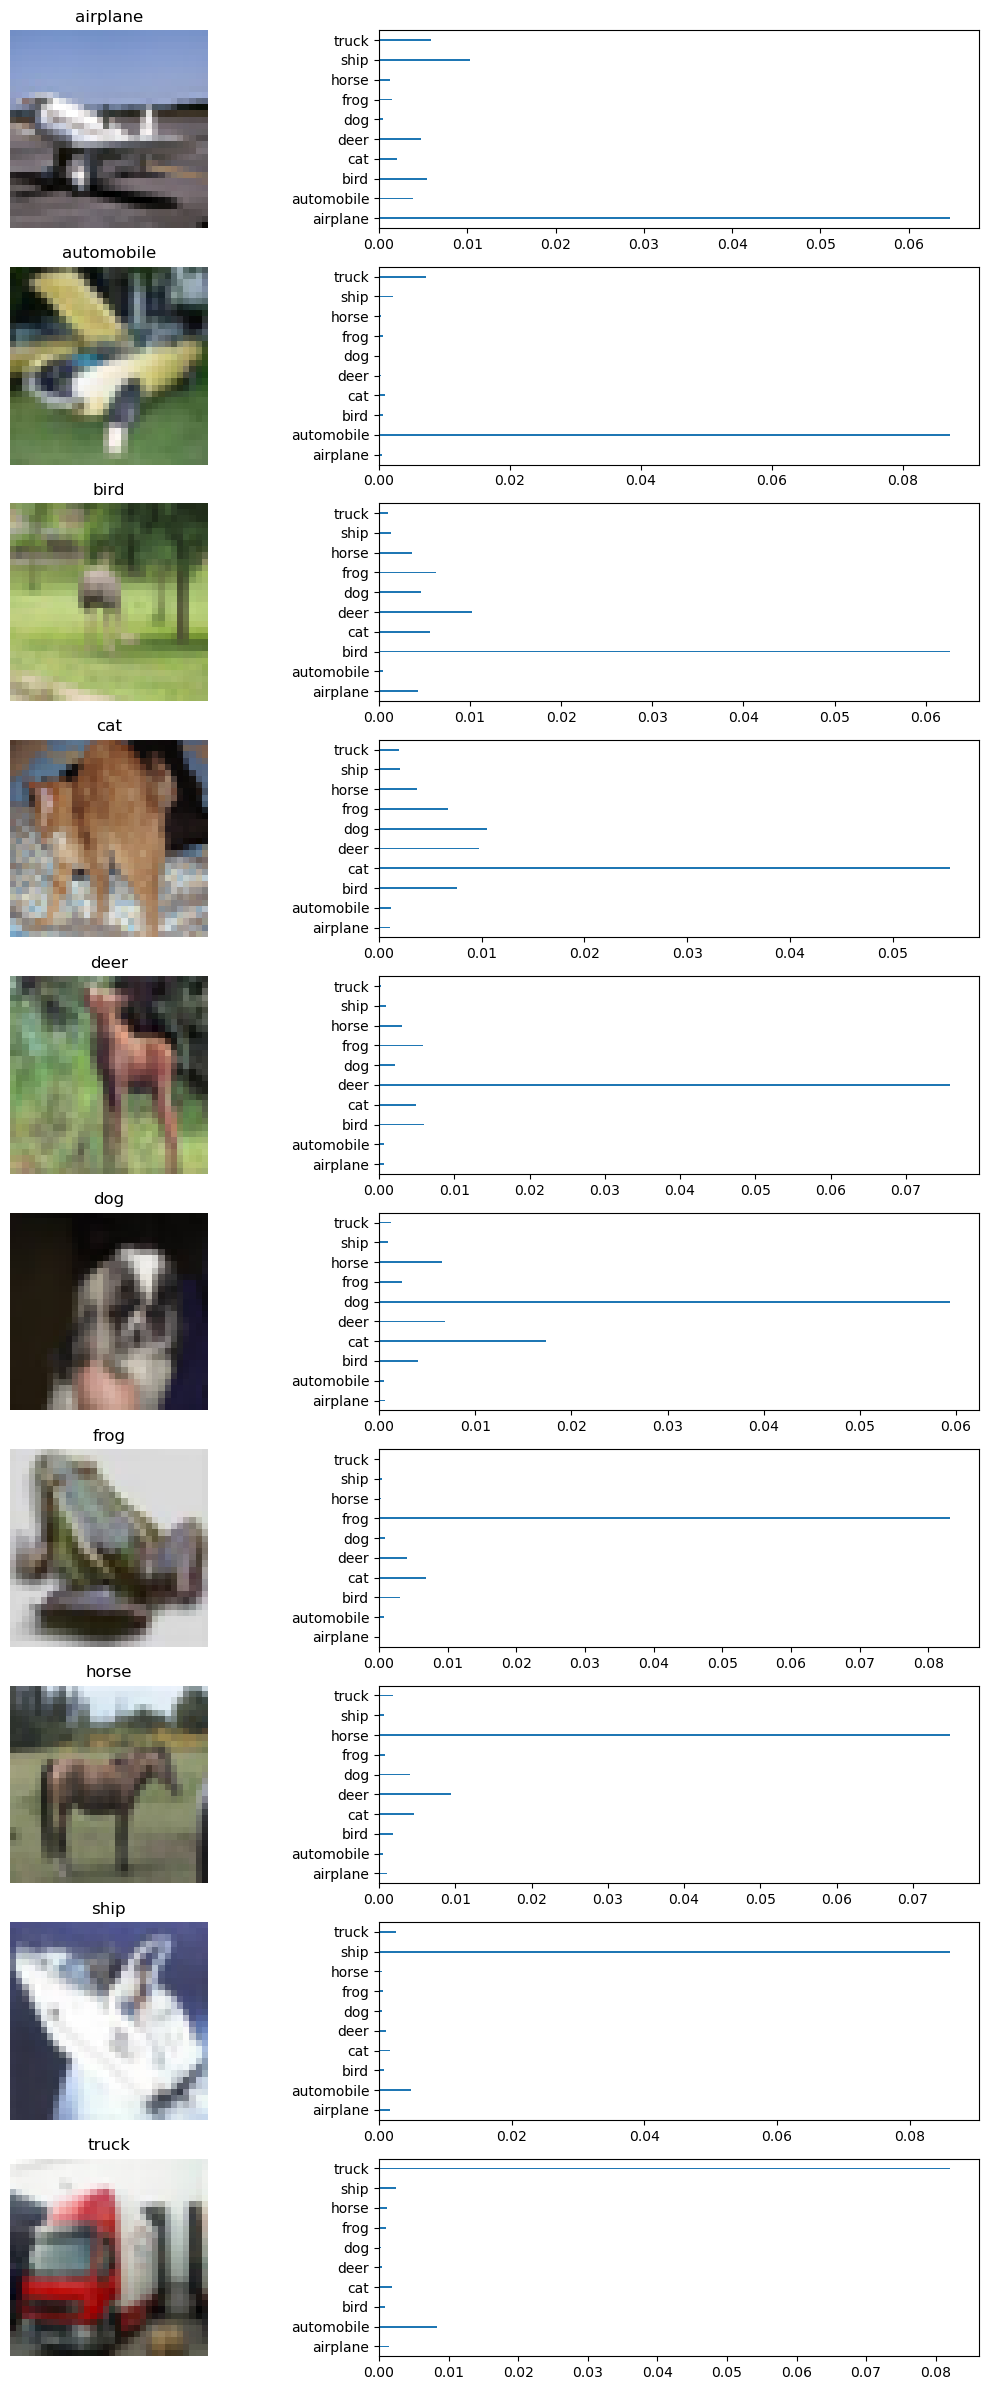

In [11]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    arr_features = [None]*10
    arr_predictions = np.zeros((10, 10))
    last_image_i = 0
    
    for i, prediction in enumerate(predictions):
        label_id = label_ids[i]
        feature = features[i]
        arr_features[label_id] = feature
        max_id = np.argmax(prediction)
        arr_predictions[label_id][max_id] += 1
        last_image_i = i

    arr_predictions /= last_image_i
    
    for i in range(10):
      feature = arr_features[i]
      pred_name = label_names[i]
      prediction = arr_predictions[i]
      axs[i][0].imshow(feature)
      axs[i][0].set_title(pred_name)
      axs[i][0].set_axis_off()

      axs[i][1].barh(ind + margin, prediction, width)
      axs[i][1].set_yticks(ind + margin)
      axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

display_image_predictions(x_test, y_test, predictions)